In [4]:
import nltk   
import spacy            
import re     
import string            
import numpy as np
import pandas as pd
import random
import collections
import time
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples    # Corpus Twitter
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

Lectura de Corpus

In [5]:
nltk.download('twitter_samples')

[nltk_data] Error loading twitter_samples: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

In [6]:
pos_tweets = twitter_samples.strings('positive_tweets.json') #tweets positivos
neg_tweets = twitter_samples.strings('negative_tweets.json') #tweets negativos

print("Positive tweets: ", len(pos_tweets))
print("Negative tweets: ", len(neg_tweets))

Positive tweets:  5000
Negative tweets:  5000


Preprocesamiento


1. LowerCase
2. Lematización / Stemming
3. Remover stopword
4. Remover signos de puntuación
4. Remover urls y manejadores





In [7]:
def custom_tokenizer(nlp):
    special_cases = {":)": [{"ORTH": ":)"}], ":(": [{"ORTH": ":("}]}
    simple_url_re = re.compile(r'''^https?://''')
    suffixes = nlp.Defaults.suffixes + [r'''-+$''',]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, rules=special_cases, suffix_search=suffix_regex.search, url_match=simple_url_re.match)

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)


In [8]:
def normalization(data, regularization="lemma", language='english'):
  stopwords = nltk.corpus.stopwords.words(language)
  ps = PorterStemmer()
  normalized_data = []
  
  for tweet in data:
    tweet = re.sub(r'^RT[\s]+', '', tweet) # identificar retweets
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) #eliminar links
    tweet = re.sub(r'#', '', tweet) #eliminar símbolo gato
    tweet = re.sub(r'@\w+', '', tweet) #eliminar palabras que inicias con @
    tweet = re.sub(r'\d+', '', tweet) #eliminar números
    tweet = re.sub(' +', ' ', tweet) #quitar espacios

    if regularization == "stem":
      tweetTokenizer = TweetTokenizer()
      words = tweetTokenizer.tokenize(tweet)
      tokens = [ps.stem(w) for w in words]
    if regularization == "lemma":
      doc = nlp(tweet)
      tokens = [token.lemma_ for token in doc]
    else:
      doc = nlp(tweet)
      tokens = [token.text for token in doc]
    
    normalized_tweets = [w.lower() for w in tokens if w.lower() not in stopwords and not w==' ' and w not in string.punctuation]
    normalized_data.append(normalized_tweets)
  return normalized_data

Create Vocabulary and frequency dictionaries

In [9]:
norm_pos = normalization(pos_tweets)
norm_neg = normalization(neg_tweets)
all_tweets = norm_pos + norm_neg
at = [w for tweet in all_tweets for w in tweet]
fd = nltk.FreqDist(at)
vocabulary = sorted(list(fd.keys()))

print('\nThe vocabulary has %d words.\n' %len(vocabulary))



The vocabulary has 11260 words.



In [10]:
X_features = []
for text in all_tweets:
  vector = [1] # initialize in 1 ?
  for voc in vocabulary:
    # In vector saves a list of vocabulary's length. 
    # Iterate each vocabulary word and count in each text list
    vector.append(text.count(voc))
  X_features.append(vector)

print('\nX_features matrix has m = %d examples (rows).\n' %len(X_features))
print('and  n = %d features (columns).\n' %len(X_features[0]))


X_features matrix has m = 10000 examples (rows).

and  n = 11261 features (columns).



In [11]:
tags = [1]*len(pos_tweets) + [0]*len(neg_tweets)

In [45]:
#Principal component analysis
def compute_pca(X, k_components=2, tolerance=0.01):
    """
    Entrada:
        X: Dimensión (m,n) donde n son las características y m son los ejemplos
        k_components: Number of components you want to keep.
    Salida:
        X_reduced: Datos transformados con k_components dimensiones
    """

    # Centrar los datos de entrada a su media
    X_demeaned = X - np.mean(X, axis=0, keepdims=True)

    # Calcula la matriz de covarianza
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # Calcula los eigenvectores y eigenvalores de la matriz de covarianza
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')

    # Retorna los índices que ordenarían los eigenvalores de mayor a menor
    idx_sorted = np.argsort(-eigen_vals)

    # Ordena los eigenvalores por idx_sorted
    eigen_vals_sorted = eigen_vals[idx_sorted]

    # Ordena los eigenvectores usando los indices idx_sorted 
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted]

    # Selecciona los primeros k eigenvectores
    eigen_vecs_subset = eigen_vecs_sorted[:,0:k_components]

    # Selecciona los primeros k eigenvalores
    eigen_vals_subset = eigen_vals_sorted[:k_components]

    # Calcula la pérdida de información (Varianza), un numero aceptable es < 0.01
    variance = 1 - (sum(eigen_vals_subset) / sum(eigen_vals))
    if variance <= tolerance:
        print("Pérdida de información aceptable")
    else:
        print("PÉRDIDA DE INFORMACIÓN IMPORTANTE - AUMENTA K-COMPONENTS")

    print("Porcentaje de pérdida de información del " + str(round(1 - (variance*100), 4)) + "%")

    # Transforma los datos, por la multiplicación de la transpuesta de los eigenvectores
    # con la transpuesta de los datos de entrada centrados a su media
    X_reduced = np.matmul(eigen_vecs_subset.T, X_demeaned.T)
    X_reduced = X_reduced.T

    return X_reduced

In [73]:
X_features_pca = compute_pca(X_features, k_components=2500)

PÉRDIDA DE INFORMACIÓN IMPORTANTE - AUMENTA K-COMPONENTS
Porcentaje de pérdida de información del 7.5864%


In [74]:
"""Shuffle list"""
tuple_list = list(zip(X_features_pca, tags)) #list of tuples (X,y)
random.seed(30)
random.shuffle(tuple_list)
X_, y_ = zip(*tuple_list)

X = list(X_)
y = list(y_)

In [75]:
"""split corpus into test(20%) and train(80%)"""
test_percentage = 0.2
split = int(len(X) * test_percentage)
X_test = X[:split]
y_test = y[:split]
X_train = X[split:]
y_train = y[split:]

m_train = len(X_train) #number of examples in X_train
m_test = len(X_test) #number of examples in X_test
n = len(X_train[0]) #features

In [76]:
"""Convert to array"""
import numpy as np
X_train = np.array(X_train).T
X_test = np.array(X_test).T
y_train = np.array(y_train)
y_test = np.array(y_test)
print('features: ', n)
print('shape X_train: ', X_train.shape)
print('shape X_test: ', X_test.shape)

y_train = y_train.reshape((m_train, 1))
y_test = y_test.reshape((m_test, 1))
print('shape y_train: ', y_train.shape)
print('shape y_test: ', y_test.shape)

features:  2500
shape X_train:  (2500, 8000)
shape X_test:  (2500, 2000)
shape y_train:  (8000, 1)
shape y_test:  (2000, 1)


In [77]:
def sigmoid(z):
  sigmoide = np.where(z < 0, np.exp(z)/(1 + np.exp(z)), 1/(1 + np.exp(-z)))
  return sigmoide
  #return 1/(1 + np.exp(-z)) 

In [78]:
def log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps) #limitar los valores del array en el rango eps y 1 - eps
    loss = - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
    return np.mean(loss)

In [79]:
def gradient_descent(h_theta, y, X):
  return (1/len(y)) * np.dot((h_theta - y).T,X.T) # 1xm dot mxn ->1xn

In [80]:
""" Train """
epochs = 1500
learning_rate = 2
costs = []
theta = np.zeros((n,1)) #-> nx1

start_time = time.time()
for i in range(epochs):
  z = np.dot(theta.T, X_train) #->1xm
  h_theta = sigmoid(z.T)#->mx1, h_theta or y_pred
  #Calculate cost
  cost = log_loss(y_train,h_theta) #scalar
  costs.append(cost)

  if i%100 == 0:
    print('Cost in epoch', i, 'is', cost)
    
  #Gradient descent
  d_theta = gradient_descent(h_theta, y_train, X_train).T #->nx1
  theta = theta - learning_rate * d_theta #->nx1


end_time = time.time()
epoch_time = end_time - start_time
print("Execution time : {:.2f} seconds".format(epoch_time))
  

Cost in epoch 0 is 0.6931471805599454
Cost in epoch 100 is 0.0960217060090248
Cost in epoch 200 is 0.08271218007378275
Cost in epoch 300 is 0.07588859035218402
Cost in epoch 400 is 0.07129008966811835
Cost in epoch 500 is 0.06780588165345185
Cost in epoch 600 is 0.06499216844033448
Cost in epoch 700 is 0.0626282888037662
Cost in epoch 800 is 0.06058856028568687
Cost in epoch 900 is 0.05879442280178083
Cost in epoch 1000 is 0.05719334038859968
Cost in epoch 1100 is 0.05574833864448995
Cost in epoch 1200 is 0.05443233725432229
Cost in epoch 1300 is 0.05322486088117227
Cost in epoch 1400 is 0.05211002177205346
Execution time : 61.86 seconds


Text(0.5, 1.0, 'Learning curve')

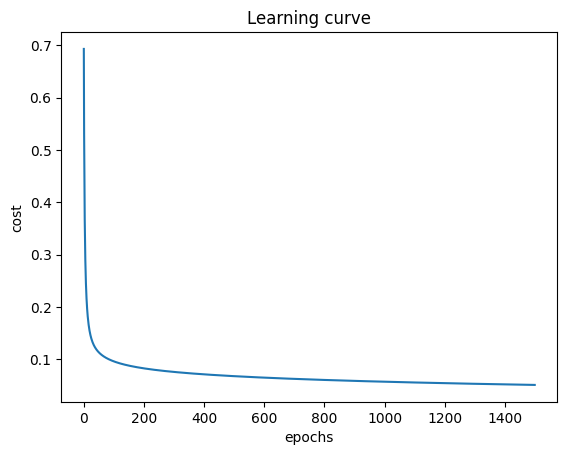

In [81]:
#Plot train cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title("Learning curve")

In [82]:
def evaluation(theta,X):
  #X -> nxm
  #theta.T ->1xn
  z = np.dot(theta.T, X) #->1xm
  return sigmoid(z.T)#->mx1

In [83]:
def classify_tag(y_pred_list,threshold):
  return [1 if y >= threshold else 0 for y in y_pred_list]

In [84]:
def confusion_matrix_values(y_pred, y_label):
  TP, FN, FP, TN = 0 , 0 , 0, 0
  for i in range(len(y_pred)):
    if y_pred[i] == 1 and  y_label[i] == 1:
      TP = TP + 1
    elif y_pred[i] == 1 and y_label[i] == 0:
      FP = FP + 1
    elif y_pred[i] == 0 and y_label[i] == 1:
      FN = FN + 1
    else:
      TN = TN + 1
  return TP, FN, FP, TN

In [85]:
"""Measures"""

def measures(TP, FN, FP, TN):
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  fallout = FP / (FP + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F = (precision * recall) / (precision + recall)
  F1 = (2 * precision * recall)/(precision + recall)
  print("Presicion: ", precision)
  print("Recall: ", recall)
  print("F: ", F)
  print("F1: ", F1)
  print("Fallout: ", fallout)
  print("Accuracy: ", accuracy)

In [86]:
"""Evaluation for Train"""

threshold = 0.5
y_train_pred_prob = evaluation(theta,X_train)
y_train_pred = classify_tag(y_train_pred_prob, threshold) #Classify to 0 (ham) or 1 (spam)
TP, FN, FP, TN = confusion_matrix_values(y_train_pred, y_train)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

3961 24 99 3916
Presicion:  0.975615763546798
Recall:  0.9939774153074028
F:  0.492355500310752
F1:  0.984711000621504
Fallout:  0.024657534246575342
Accuracy:  0.984625


In [87]:
"""Evaluation for Test"""

y_test_pred_prob = evaluation(theta,X_test)
y_test_pred = classify_tag(y_test_pred_prob, threshold) #Classify to 0 (ham) or 1 (spam)
TP, FN, FP, TN = confusion_matrix_values(y_test_pred, y_test)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

988 27 54 931
Presicion:  0.9481765834932822
Recall:  0.9733990147783251
F:  0.4803111327175498
F1:  0.9606222654350997
Fallout:  0.05482233502538071
Accuracy:  0.9595


Usando scikit-learn

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=50)
target_names = ['class 0', 'class 1']

In [90]:
# Creamos el modelo de regresión logística
modelo = LogisticRegression()
# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)
predicciones = modelo.predict(X_test)
# Evaluamos el modelo
puntaje = modelo.score(X_test, y_test)
# Imprimimos el puntaje obtenido
print("Puntaje: ", puntaje)
print(classification_report(y_test, predicciones, target_names=target_names, digits=4))

Puntaje:  0.955
              precision    recall  f1-score   support

     class 0     0.9666    0.9411    0.9537       985
     class 1     0.9443    0.9685    0.9562      1015

    accuracy                         0.9550      2000
   macro avg     0.9555    0.9548    0.9550      2000
weighted avg     0.9553    0.9550    0.9550      2000

